- Basile Álvarez Andrés José
- Keller Ascencio Rodolfo Andrés

In [1]:
# The MIT License (MIT) Copyright (c) 2023 milmor
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# FastGAN
- En este notebook se define una arquitectura basada en [FastGAN](https://arxiv.org/abs/2101.04775).
- El código completo en Tensorflow se encuentra en [este repositorio](https://github.com/milmor/self-supervised-gan).

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

- Descarga dataset.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_images.shape

(60000, 28, 28, 1)

## 1.- Pipeline

In [5]:
def deprocess(img):
    return img * 127.5 + 127.5

In [23]:
def create_ds(images, labels, batch_size, seed=15):
    BUFFER_SIZE = images.shape[0]
    img_ds = tf.data.Dataset.from_tensor_slices((images, labels)) #Recibir imágenes y etiquetas
    ds = img_ds.cache().shuffle(
        BUFFER_SIZE, seed=seed).batch(
        batch_size, drop_remainder=True, num_parallel_calls=AUTOTUNE).prefetch(
        AUTOTUNE
    )
    print(f'Train dataset size: {BUFFER_SIZE}')
    print(f'Train batches: {tf.data.experimental.cardinality(ds)}')
    return ds

batch_size = 256
train_dataset = create_ds(train_images, train_labels, batch_size)

Train dataset size: 60000
Train batches: 234


In [24]:
train_batch, train_labels = next(iter(train_dataset))

In [25]:
train_batch.shape, train_labels.shape

(TensorShape([256, 28, 28, 1]), TensorShape([256]))

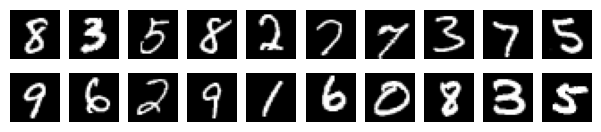

In [26]:
def plot_batch(batch):
    plt.figure(figsize=(7.5, 1.5))
    n_images = 20
    plot_batch = tf.cast(deprocess(batch), tf.uint8)
    for i in range(n_images):
        plt.subplot(2, 10, i+1)
        plt.imshow(plot_batch[i, :, :, :], cmap='gray')
        plt.axis('off')
    plt.show()

plot_batch(train_batch)

## 2.- Modelo
### Generador
- Define bloque para UpSampling.

In [27]:
def upBlock(filters, kernel_size=3, initializer='orthogonal'):
    block = tf.keras.Sequential([
            layers.UpSampling2D(2),
            layers.Conv2D(filters*2, kernel_size=kernel_size,
                padding='same', use_bias=False,
                kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
    ])
    return block

In [28]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters=128, dense_units=512, initializer='glorot_uniform'):
        super(Generator, self).__init__()
        self.init = tf.keras.Sequential([
            layers.Dense(7 * 7 * dense_units,
                         use_bias=False, kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Reshape((7, 7, dense_units))
        ])
        self.up_14 = upBlock(filters, initializer=initializer)
        self.up_28 = upBlock(filters // 2, initializer=initializer)

        self.ch_conv = layers.Conv2D(1, 3, padding='same',
                                     activation='tanh', kernel_initializer=initializer)

        self.emb = layers.Embedding(10, 128, name="embeddings")

    def call(self, z, c):
        c = self.emb(c)         #Pasamos lote de clases por embeddings
        # print(z.shape, c.shape)
        z = tf.concat([z,c],-1)
        # print(z.shape)
        feat_4 = self.init(z)
        feat_8 = self.up_14(feat_4)
        feat_16 = self.up_28(feat_8)
        img = self.ch_conv(feat_16)
        return img


noise_dim = 64
noise = tf.random.normal([batch_size, noise_dim]) #Vector latente
generator = Generator(64, 64)
gen_batch = generator(noise, train_labels)
generator.summary()
gen_batch.shape

Model: "generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (256, 7, 7, 64)           614656    
                                                                 
 sequential_16 (Sequential)  (256, 14, 14, 128)        74240     
                                                                 
 sequential_17 (Sequential)  (256, 28, 28, 64)         73984     
                                                                 
 conv2d_14 (Conv2D)          multiple                  577       
                                                                 
 embeddings (Embedding)      multiple                  1280      
                                                                 
Total params: 764,737
Trainable params: 758,081
Non-trainable params: 6,656
_________________________________________________________________


TensorShape([256, 28, 28, 1])

### Discriminador

- Define bloque residual.

In [29]:
def convBlock(filters, kernel_size=3, strides=1, padding='same',
              use_bias=False, kernel_initializer='orthogonal', use_bn=True):
    if use_bn:
        block = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=kernel_size, strides=strides,
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer),
            layers.BatchNormalization()
         ])
    else:
        block = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides,
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer)
    return block

In [30]:
class DownBlockComp(layers.Layer):
    def __init__(self, filters, initializer='orthogonal', use_bn=True):
        super(DownBlockComp, self).__init__()

        self.main = tf.keras.Sequential([
            convBlock(filters, kernel_size=4, padding='same',
                strides=2, use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
            convBlock(filters, kernel_size=3, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])

        self.direct = tf.keras.Sequential([
            layers.AveragePooling2D((2, 2)),
            convBlock(filters, kernel_size=1, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])

    def call(self, x):
        return (self.main(x) + self.direct(x)) / 2

In [31]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters=128, initializer='orthogonal', use_bn=True):
        super(Discriminator, self).__init__()
        '''Encode image'''
        self.down_from_big = tf.keras.Sequential([
            layers.Conv2D(filters // 4, kernel_size=3, padding='same',
                use_bias=False, kernel_initializer=initializer),
            layers.LeakyReLU(0.2)
        ])
        self.down_16 = DownBlockComp(filters // 2, initializer=initializer, use_bn=use_bn)
        self.down_8 = DownBlockComp(filters, initializer=initializer, use_bn=use_bn)

        '''Logits'''
        self.logits = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=1, padding='valid',
                use_bias=False, kernel_initializer=initializer),
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, kernel_size=4, padding='valid',
                use_bias=False, kernel_initializer=initializer),
            layers.Flatten()
        ])


        self.emb = layers.Embedding(10, 128, name="embeddings")

    def call(self, img, c):
        B = c.shape[0]
        c = self.emb(c)
        # print(c.shape)                  #Tensor 256,128
        c = tf.reshape(c,[B,1,1,-1])    #Se expande para poder hacer operaciones entre tensores
        # print(c.shape)
        c = tf.tile(c, [1,7,7,1])       #Repetimos 7 veces en eje x y 7 veces en eje y
        # print(img.shape, c.shape)
        feat_32 = self.down_from_big(img)
        feat_16 = self.down_16(feat_32)
        feat_8 = self.down_8(feat_16)
        # print(logits.shape)
        feat_8 = tf.concat([feat_8, c], -1)
        # print(feat_8.shape)
        logits = self.logits(feat_8)

        return logits


discriminator = Discriminator(128, use_bn=True)
out_disc = discriminator(train_batch, train_labels)
discriminator.summary()
out_disc.shape

Model: "discriminator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (256, 28, 28, 32)         288       
                                                                 
 down_block_comp_2 (DownBloc  multiple                 72448     
 kComp)                                                          
                                                                 
 down_block_comp_3 (DownBloc  multiple                 288256    
 kComp)                                                          
                                                                 
 sequential_29 (Sequential)  (256, 16)                 34816     
                                                                 
 embeddings (Embedding)      multiple                  1280      
                                                                 
Total params: 397,088
Trainable params: 395,936
Non

TensorShape([256, 16])

## 3.- Entrenamiento
- Define funciones objetivo y optimizadores.

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
g_lr = 0.0001
d_lr = 0.0001
beta_1 = 0.5
beta_2 = 0.9

g_opt = tf.keras.optimizers.Adam(learning_rate=g_lr,
                                 beta_1=beta_1,
                                 beta_2=beta_2)

d_opt = tf.keras.optimizers.Adam(learning_rate=d_lr,
                                 beta_1=beta_1,
                                 beta_2=beta_2)

- Define GAN.

In [35]:
class GAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator, g_opt, d_opt, g_loss, d_loss):
        super(GAN, self).__init__()
        self.generator = generator
        self.g_opt = g_opt
        self.g_loss = g_loss
        self.discriminator = discriminator
        self.d_opt = d_opt
        self.d_loss = d_loss

        # Log metrics
        self.g_loss_avg = tf.keras.metrics.Mean()
        self.d_loss_avg = tf.keras.metrics.Mean()

    @tf.function
    def train_step(self, real_img, real_label):
        noise = tf.random.normal([batch_size, noise_dim])

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            gen_img = self.generator(noise, real_label, training=True)
            real_out = self.discriminator(real_img, real_label, training=True)
            fake_out = self.discriminator(gen_img, real_label, training=True)

            disc_loss = self.d_loss(real_out, fake_out)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, noise_dim])

        # Train the generator
        with tf.GradientTape() as gen_tape:
            generator_output = self.generator(noise, real_label, training=True)
            fake_out = self.discriminator(generator_output, real_label, training=True)

            gen_loss = self.g_loss(fake_out)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        self.g_loss_avg(gen_loss)
        self.d_loss_avg(disc_loss)

- Define modelo.

In [36]:
gan = GAN(generator, discriminator,
          g_opt, d_opt,
          generator_loss, discriminator_loss)

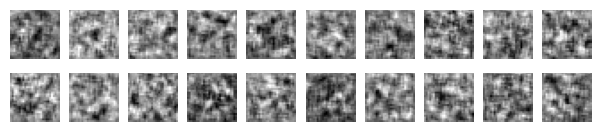

In [37]:
noise = tf.random.normal([batch_size, noise_dim])
gen_batch = gan.generator(noise, train_labels)

plot_batch(gen_batch)

In [38]:
noise_seed = tf.random.normal([batch_size, noise_dim])

In [39]:
epochs = 24
plot_inter = 3

def train(model, epochs, dataset, plot_inter):
    for epoch in range(epochs):
        start = time.time()
        for image_batch, labels_batch in dataset:
            model.train_step(image_batch, labels_batch)

        g_loss = model.g_loss_avg.result()
        d_loss = model.d_loss_avg.result()
        print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec', end=' ')
        print(F'G loss: {g_loss:.4f} D loss: {d_loss:.4f}')
        if epoch % plot_inter == 0:
            gen_batch = model.generator(noise_seed, train_labels, training=False)
            plot_batch(gen_batch)

        model.g_loss_avg.reset_states()
        model.d_loss_avg.reset_states()

Time for epoch 0 is 34.9494 sec G loss: 2.0205 D loss: 0.4977


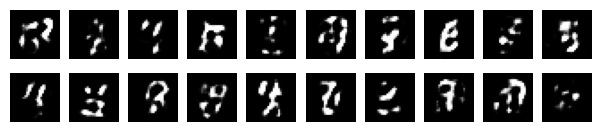

Time for epoch 1 is 22.7886 sec G loss: 2.9613 D loss: 0.3601
Time for epoch 2 is 22.9832 sec G loss: 3.2353 D loss: 0.3338
Time for epoch 3 is 23.1756 sec G loss: 3.2309 D loss: 0.3433


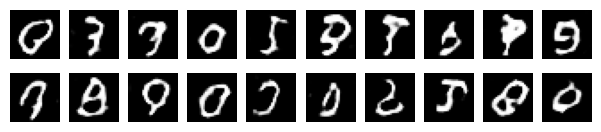

Time for epoch 4 is 23.3417 sec G loss: 3.1649 D loss: 0.3794
Time for epoch 5 is 23.4476 sec G loss: 3.0772 D loss: 0.3881
Time for epoch 6 is 23.5709 sec G loss: 3.1299 D loss: 0.3899


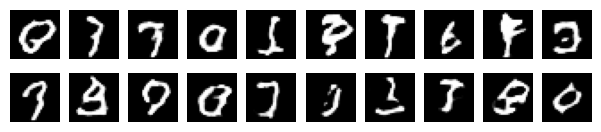

Time for epoch 7 is 23.6773 sec G loss: 3.2367 D loss: 0.3661
Time for epoch 8 is 23.6864 sec G loss: 3.3236 D loss: 0.3774
Time for epoch 9 is 23.6762 sec G loss: 3.3177 D loss: 0.3624


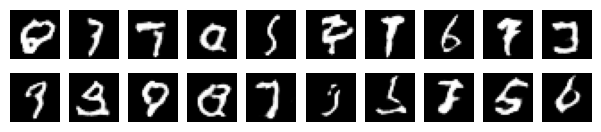

Time for epoch 10 is 23.7864 sec G loss: 3.2273 D loss: 0.4026
Time for epoch 11 is 24.0642 sec G loss: 3.1486 D loss: 0.4388
Time for epoch 12 is 24.1346 sec G loss: 3.0595 D loss: 0.4584


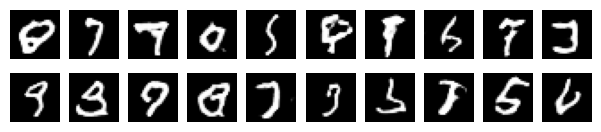

Time for epoch 13 is 23.9840 sec G loss: 2.9305 D loss: 0.4652
Time for epoch 14 is 24.0496 sec G loss: 2.8979 D loss: 0.4661
Time for epoch 15 is 24.0544 sec G loss: 2.8946 D loss: 0.4784


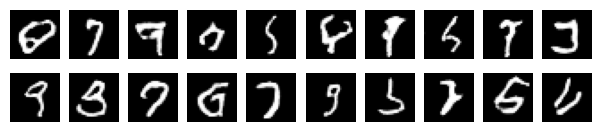

Time for epoch 16 is 24.0061 sec G loss: 2.8956 D loss: 0.4696
Time for epoch 17 is 24.0052 sec G loss: 2.8965 D loss: 0.4588
Time for epoch 18 is 24.0738 sec G loss: 2.9717 D loss: 0.4477


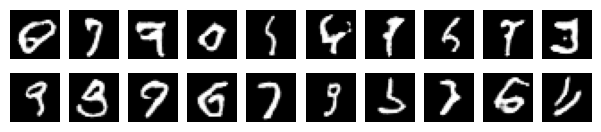

Time for epoch 19 is 24.0579 sec G loss: 2.9986 D loss: 0.4441
Time for epoch 20 is 24.0566 sec G loss: 3.0098 D loss: 0.4336
Time for epoch 21 is 24.0565 sec G loss: 3.0649 D loss: 0.4306


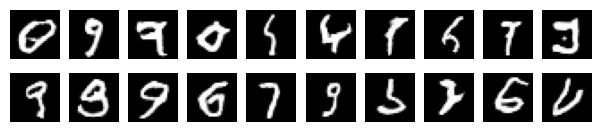

Time for epoch 22 is 24.0781 sec G loss: 3.0496 D loss: 0.4229
Time for epoch 23 is 24.1375 sec G loss: 3.0997 D loss: 0.4278


In [40]:
train(gan, epochs, train_dataset, plot_inter)

## Ejercicio
- Convierte al modelo a una [GAN condicionada](https://arxiv.org/abs/1411.1784). En este modelo, el generador y el discriminador reciben un vector de etiqueta:

\begin{equation}
V(G, D) = \mathbb{E}_{x \sim p_{\text{r}}(x|y)}[\log D(x|y)] + \mathbb{E}_{z \sim p_{z}(z)}[\log (1 - D(G(z|y)))]
\label{eq:conditional_gan}
\end{equation}

Pasar etiqueta a discriminador y a generador

Si tenemos diez clases el tamaño del vocabulario es 10, vamos a tener un vector para cada digito.

Ejecutar pipeline